# ============================
# Imports et préparations
# ============================

In [1]:
# 🔧 Librairies fondamentales
!pip install pandas numpy scikit-learn

# 🔥 PyTorch (si tu es sur CPU uniquement)
!pip install torch torchvision torchaudio

# 📊 Visualisation
!pip install matplotlib seaborn

!pip install tqdm
!pip install nltk spacy


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import re


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/ericcosterousse/.pyenv/versions/3.11.0/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/ericcosterousse/.pyenv/versions/3.11.0/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/ericcosterousse/.pyenv/versions/3.11.0/lib/python3.11/site-packages/ipykernel/kernelapp

In [3]:
print(torch.__version__)

2.2.2


# ============================
# 1. Chargement et nettoyage
# ============================

In [4]:
# Chargement du corpus textuel
# On suppose que chaque ligne est un document/article
# La colonne "text" contient le texte brut

df = pd.read_csv("../data/articles3.csv")
texts = df["text"].astype(str).tolist()  # conversion explicite en string au cas où

In [5]:
df['section'].unique()

array(['Business', 'Politics', 'Culture', 'Sport', 'Technology',
       'World news'], dtype=object)

In [6]:
import re
import nltk
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

class Preprocessing:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stop_words.update(['u', 'us', 'q', 'said', 'say', 'year', 'company', 'government', 'uk', 'time', 'new', 'people', 'party', 'labour'])
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """
        Nettoyage du texte : minuscules, suppression HTML, ponctuation, chiffres, espaces multiples.
        """
        if not isinstance(text, str):
            return ""

        text = text.lower()
        # Normalisation unicode (accents etc.)
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    
        # Supprimer les URLs (http, https, www)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
        # Supprimer les emails
        text = re.sub(r'\S+@\S+', '', text)
    
        # Supprimer ponctuation et chiffres, garder lettres et espaces uniquement
        # (on enlève aussi les acronymes avec points en une fois)
        text = re.sub(r'\b[a-z]\.', '', text)  # enlever lettres suivies d'un point (ex: u.)
        text = re.sub(r'[^a-z\s]', ' ', text)  # garder lettres et espaces uniquement
    
        # Enlever espaces multiples
        text = re.sub(r'\s+', ' ', text).strip()
    
        return text
    
    def tokenize(self, text):
        """
        Tokenisation simple par split des mots.
        """
        return text.split()
    
    def remove_stopwords(self, tokens):
        """
        Suppression des stopwords.
        """
        filtered = [token for token in tokens if token not in self.stop_words]  
        return filtered
    
    def lemmatize(self, tokens):
        """
        Lemmatisation des tokens.
        """
        return [self.lemmatizer.lemmatize(token) for token in tokens]
    
    def preprocess(self, text):
        """
        Pipeline complet combinant toutes les étapes
        """
        cleaned = self.clean_text(text)
        tokens = self.tokenize(cleaned)
        no_stop = self.remove_stopwords(tokens)
        lemmas = self.lemmatize(no_stop)
        return " ".join(lemmas)


In [7]:
preprocess = Preprocessing()
df["text_cleaned"] = df["text"].astype(str).apply(preprocess.preprocess)

In [8]:
df.head()

,section,title,text,text_cleaned
0,Business,Bank of England expected to leave interest rat...,The Bank of England’s policymakers may not be ...,bank england policymakers may united today pro...
1,Business,"Federal Reserve holds interest rates, defying ...",The US Federal Reserve kept interest rates on ...,federal reserve kept interest rate hold signal...
2,Business,John Lewis tells some head office staff to wor...,John Lewis is asking some head office staff to...,john lewis asking head office staff spend leas...
3,Business,What could Albanese do to improve productivity...,In his address last week at the National Press...,address last week national press club prime mi...
4,Business,EU accuses China’s AliExpress of ‘systemic fai...,The European Commission has accused the online...,european commission accused online retailer al...


# ============================
# 2. Vectorisation TF-IDF
# ============================

In [9]:
texts_cleaned = df['text_cleaned'].astype(str).tolist()

In [10]:
# Transformation des textes en vecteurs via TF-IDF
# Chaque texte devient un vecteur de dimension 7500
# Chaque dimension correspond à un mot important (en anglais ici)

vectorizer = TfidfVectorizer(max_features=7500)
X_tfidf = vectorizer.fit_transform(texts_cleaned).toarray()
print(f"[INFO] TF-IDF shape : {X_tfidf.shape}")  # ex : (n_documents, 7500)

[INFO] TF-IDF shape : (60000, 7500)


In [11]:
from sklearn.preprocessing import StandardScaler

# ⚠️ Pas de normalisation L2 ici
# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tfidf)

# Conversion en tenseur
X_tensor_scaled = torch.tensor(X_scaled, dtype=torch.float32)

In [12]:
from sklearn.preprocessing import normalize

# Normalisation L1 des vecteurs TF-IDF
X_tfidf_l1 = normalize(X_tfidf, norm='l2')

In [13]:
# Conversion vers un tenseur PyTorch (utile pour l'entraînement)
X_tensor_l1 = torch.tensor(X_tfidf_l1, dtype=torch.float32)

# ============================
# 3. Autoencodeur en PyTorch
# ============================

In [14]:
# Construction d'un autoencodeur :
# C'est un réseau neuronal qui apprend à reproduire son entrée à la sortie
# En forçant une couche cachée plus petite (ici 32), on obtient une compression (encoding)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super(Autoencoder, self).__init__()

        # Partie encodeur (on réduit la dimension jusqu'à 32)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, hidden_dim),
            nn.ReLU()
        )

        # Partie decodeur (on reconstruit les données originales)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, input_dim),
            nn.Sigmoid() 
        )

    def forward(self, x):
        X_encoded = self.encoder(x)
        decoded = self.decoder(X_encoded)
        return decoded

In [15]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [19]:
# Instanciation du modèle
input_dim_l1 = X_tensor_l1.shape[1]  # taille des vecteurs TF-IDF normalize l1
model_l1 = Autoencoder(input_dim=input_dim_l1)

In [20]:
# Instanciation du modèle
input_dim_scaled = X_tensor_scaled.shape[1]  # taille des vecteurs TF-IDF scaled
model_scaled = Autoencoder(input_dim=input_dim_scaled)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📟 Using device: {device}")

📟 Using device: cpu


# ============================
# 4. Entraînement de l'autoencodeur
# ============================

In [22]:
# Fonction de perte = MSE (erreur quadratique moyenne entre sortie et entrée)
# Optimiseur = SGD (Stochastic Gradient Descent) est plus fondamental,
# fonctionne bien lorsqu’il est combiné avec du momentum. Le momentum joue le rôle d’un « amortisseur » en reprenant l’idée physique de la vitesse d’un corps : il aide à traverser les minima locaux et à accélérer dans les vallées du paysage de perte.
criterion_l1 = nn.MSELoss()
optimizer_l1 = torch.optim.SGD(model_l1.parameters(), lr=0.001, momentum = 0.9)
early_stopper_l1 = EarlyStopping(patience=3)

In [23]:
# On transforme nos données en un DataLoader pour le mini-batch training
# Chaque batch contient 32 documents TF-IDF

from torch.utils.data import TensorDataset, DataLoader, random_split

# Crée un dataset complet avec tes données
full_dataset = TensorDataset(X_tensor_l1)

# Détermine la taille des splits
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Sépare les données
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Crée les DataLoaders
train_loader_l1 = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_l1 = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [39]:
train_losses = []

# Entraînement sur 20 époques
n_epochs = 20
for epoch in range(n_epochs):
    model_l1.train()
    epoch_loss = 0
    for batch_x, in train_loader_l1:
        optimizer_l1.zero_grad()
        outputs = model_l1(batch_x)
        loss = criterion_l1(outputs, batch_x)
        loss.backward()
        optimizer_l1.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss)
    print(f"🧪 Epoch {epoch+1}/{n_epochs} — Loss: {epoch_loss:.4f}")

🧪 Epoch 1/20 — Loss: 182.0999
🧪 Epoch 2/20 — Loss: 175.0798
🧪 Epoch 3/20 — Loss: 168.2356
🧪 Epoch 4/20 — Loss: 161.6708
🧪 Epoch 5/20 — Loss: 155.3379
🧪 Epoch 6/20 — Loss: 149.2924
🧪 Epoch 7/20 — Loss: 143.4236
🧪 Epoch 8/20 — Loss: 137.7899
🧪 Epoch 9/20 — Loss: 132.4593
🧪 Epoch 10/20 — Loss: 127.2942
🧪 Epoch 11/20 — Loss: 122.3848
🧪 Epoch 12/20 — Loss: 117.6701
🧪 Epoch 13/20 — Loss: 113.0907
🧪 Epoch 14/20 — Loss: 108.8238
🧪 Epoch 15/20 — Loss: 104.6538
🧪 Epoch 16/20 — Loss: 100.6661
🧪 Epoch 17/20 — Loss: 96.9220
🧪 Epoch 18/20 — Loss: 93.2603
🧪 Epoch 19/20 — Loss: 89.7685
🧪 Epoch 20/20 — Loss: 86.5713


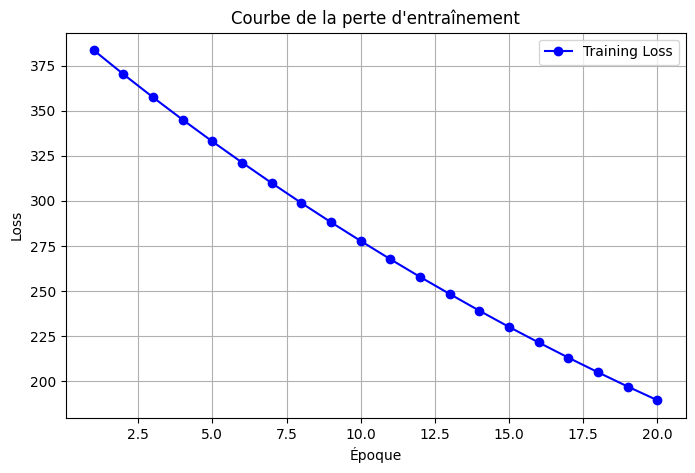

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs + 1), train_losses, marker='o', color='blue', label='Training Loss')
plt.title("Courbe de la perte d'entraînement")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [26]:
model_l1.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader_l1:
        batch_x = batch[0]
        outputs = model_l1(batch_x)
        loss = criterion_l1(outputs, batch_x)
        test_loss += loss.item()
        
epoch_loss /= len(train_loader_l1)
test_loss /= len(test_loader_l1)

print(f"Epoch {epoch+1}: Train Loss ={epoch_loss:.4f} | Test Loss={test_loss:.4f}")

print(f"🎯 Test Loss: {test_loss:.4f}")


Epoch 20: Train Loss =0.1263 | Test Loss=0.1429
🎯 Test Loss: 0.1429


In [27]:
# Fonction de perte = MSE (erreur quadratique moyenne entre sortie et entrée)
# Optimiseur = SGD (Stochastic Gradient Descent) est plus fondamental,
# fonctionne bien lorsqu’il est combiné avec du momentum. Le momentum joue le rôle d’un « amortisseur » en reprenant l’idée physique de la vitesse d’un corps : il aide à traverser les minima locaux et à accélérer dans les vallées du paysage de perte.
criterion_scaled = nn.MSELoss()
optimizer_scaled = torch.optim.SGD(model_scaled.parameters(), lr=0.001, momentum = 0.9)

In [28]:
# On transforme nos données en un DataLoader pour le mini-batch training
# Chaque batch contient 32 documents TF-IDF

dataset_scaled = TensorDataset(X_tensor_scaled, X_tensor_scaled)  # x et y sont identiques ici (autoencodeur)
loader_scaled = DataLoader(dataset_scaled, batch_size=32, shuffle=True)

# Entraînement sur 20 époques
n_epochs = 20
for epoch in range(n_epochs):
    model_scaled.train()
    epoch_loss = 0
    for batch_x, _ in loader_scaled:
        optimizer_scaled.zero_grad()
        outputs = model_scaled(batch_x)
        loss = criterion_scaled(outputs, batch_x)
        loss.backward()
        optimizer_scaled.step()
        epoch_loss += loss.item()
    print(f"🧪 Epoch {epoch+1}/{n_epochs} — Loss: {epoch_loss:.4f}")

🧪 Epoch 1/20 — Loss: 2356.0152
🧪 Epoch 2/20 — Loss: 2335.5407
🧪 Epoch 3/20 — Loss: 2315.8541
🧪 Epoch 4/20 — Loss: 2296.7582
🧪 Epoch 5/20 — Loss: 2278.3140
🧪 Epoch 6/20 — Loss: 2260.4523
🧪 Epoch 7/20 — Loss: 2243.2293
🧪 Epoch 8/20 — Loss: 2226.6101
🧪 Epoch 9/20 — Loss: 2210.6325
🧪 Epoch 10/20 — Loss: 2195.1662
🧪 Epoch 11/20 — Loss: 2180.3181
🧪 Epoch 12/20 — Loss: 2165.9858
🧪 Epoch 13/20 — Loss: 2152.2322
🧪 Epoch 14/20 — Loss: 2139.0026
🧪 Epoch 15/20 — Loss: 2126.2541
🧪 Epoch 16/20 — Loss: 2114.1103
🧪 Epoch 17/20 — Loss: 2102.4480
🧪 Epoch 18/20 — Loss: 2091.3452
🧪 Epoch 19/20 — Loss: 2080.7802
🧪 Epoch 20/20 — Loss: 2070.5382


# ============================
# 5. Encodage des textes (compression)
# ============================

In [29]:
# Une fois entraîné, on extrait les vecteurs compressés de dimension 32
model_l1.eval()
with torch.no_grad():
    compressed_vectors_l1 = model_l1.encoder(X_tensor_l1).tolist()  # liste Python

print(f"[INFO] Taille encodée : {len(compressed_vectors_l1)} x {len(compressed_vectors_l1[0])}")

[INFO] Taille encodée : 60000 x 32


In [30]:
# Une fois entraîné, on extrait les vecteurs compressés de dimension 32
model_scaled.eval()
with torch.no_grad():
    compressed_vectors_scaled = model_scaled.encoder(X_tensor_scaled).tolist()  # liste Python

print(f"[INFO] Taille encodée : {len(compressed_vectors_scaled)} x {len(compressed_vectors_scaled[0])}")

[INFO] Taille encodée : 60000 x 32


# ============================
# 6. Clustering avec KMeans
# ============================

In [31]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X_pca_l1 = PCA(n_components=2).fit_transform(compressed_vectors_l1)
clusters_l1 = KMeans(n_clusters=6, random_state=42).fit_predict(compressed_vectors_l1)
# On ajoute la colonne cluster au DataFrame original
df["cluster_l1"] = clusters_l1

/Users/ericcosterousse/.pyenv/versions/3.11.0/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [32]:
for i in range(6):
    print(f"\n📌 --- CLUSTER {i} ---")
    cluster_texts = df[df["cluster_l1"] == i]["text"].tolist()
    for text in cluster_texts[:3]:
        print(f"• {text[:200]}...")
    print(f"→ Total : {len(cluster_texts)} articles\n")


📌 --- CLUSTER 0 ---
• Steel trade unions have said it is “absolutely vital” that the UK rapidly secures a deal to protect the sector from Donald Trump’s tariffs, after the industry was excluded from an initial UK-US pact s...
• The Spanish bank Sabadell has said it has received interest from prospective buyers of its UK division TSB, and said it would assess any firm offers it may receive. Sabadell wants to sell TSB as it ba...
• Some departures from the shrinking London stock market hurt more than others. It is doubtful that Metro Bank, if it’s about to fall to an approach from a London private equity firm, will be mourned by...
→ Total : 9973 articles


📌 --- CLUSTER 1 ---
• The European Commission has accused the online retailer AliExpress of a “systemic failure” to prevent the sale of illegal and dangerous goods on its platform, as Brussels steps up its case against the...
• Qantas has rebounded from its worst-ever performance in the aviation industry’s annual awards to be named t

In [33]:
X_pca_scaled = PCA(n_components=2).fit_transform(compressed_vectors_scaled)
clusters_scaled = KMeans(n_clusters=6, random_state=42).fit_predict(compressed_vectors_scaled)
# On ajoute la colonne cluster au DataFrame original
df["cluster_scaled"] = clusters_scaled

In [34]:
for i in range(6):
    print(f"\n📌 --- CLUSTER {i} ---")
    cluster_texts = df[df["cluster_scaled"] == i]["text"].tolist()
    for text in cluster_texts[:3]:
        print(f"• {text[:200]}...")
    print(f"→ Total : {len(cluster_texts)} articles\n")


📌 --- CLUSTER 0 ---
• The Chinese owners of British Steel are gearing up to try to recover hundreds of millions of pounds of loans from the company after the UK government took over its operations. Jingye Group said it was...
• From helping consultants diagnose cancer, to aiding teachers in drawing up lesson plans – and flooding social media with derivative slop – generative artificial intelligence is being adopted across th...
• All Square, a neon-lit diner in Minneapolis, specializes in grilled cheese sandwiches with a twist. Variations on the menu include Jamaican jerk chicken with guava jam, brown sugar bacon doused in ran...
→ Total : 9328 articles


📌 --- CLUSTER 1 ---
• Donald Trump is threatening to keep 25% tariffs on some or all of its steel imports from the UK unless it gives specific guarantees over the Indian-owned steelmaking plant at Port Talbot in south Wale...
• The escalating crisis between Israel and Iran has already triggered the largest single-day oil price surge 

# ============================
# 8. Mots caractéristiques par cluster
# ============================

In [35]:
# Pour chaque cluster, on calcule la moyenne des vecteurs TF-IDF
# Puis on extrait les mots avec le plus fort score moyen

feature_names_l1 = vectorizer.get_feature_names_out()
for i in range(6):
    cluster_idx_l1 = df["cluster_l1"] == i
    cluster_tfidf_l1 = X_tfidf_l1[cluster_idx_l1]
    mean_tfidf_l1 = cluster_tfidf_l1.mean(axis=0)
    top_indices_l1 = np.argsort(mean_tfidf_l1)[::-1][:10]
    top_words_l1 = [feature_names_l1[i] for i in top_indices_l1]
    print(f"🧠 Mots caractéristiques du cluster {i} : {top_words_l1}")

🧠 Mots caractéristiques du cluster 0 : ['would', 'one', 'also', 'minister', 'first', 'could', 'like', 'say', 'last', 'world']
🧠 Mots caractéristiques du cluster 1 : ['nan', 'israel', 'israeli', 'gaza', 'one', 'would', 'game', 'ai', 'first', 'like']
🧠 Mots caractéristiques du cluster 2 : ['one', 'england', 'game', 'team', 'would', 'first', 'trump', 'last', 'player', 'year']
🧠 Mots caractéristiques du cluster 3 : ['rate', 'say', 'would', 'inflation', 'one', 'price', 'bank', 'minister', 'election', 'tax']
🧠 Mots caractéristiques du cluster 4 : ['would', 'one', 'also', 'minister', 'first', 'like', 'world', 'last', 'election', 'year']
🧠 Mots caractéristiques du cluster 5 : ['ukraine', 'trump', 'would', 'russia', 'russian', 'one', 'also', 'minister', 'musk', 'ukrainian']


In [36]:
from collections import defaultdict, Counter

# Dictionnaire pour stocker les mots top 10 par cluster
top_words_per_cluster_l1 = {}

# Récupération des top 10 mots pour chaque cluster
for i in range(6):
    cluster_idx_l1 = df["cluster_l1"] == i
    cluster_tfidf_l1 = X_tfidf_l1[cluster_idx_l1]
    mean_tfidf_l1 = cluster_tfidf_l1.mean(axis=0)
    top_indices_l1 = np.argsort(mean_tfidf_l1)[::-1][:10]
    top_words_l1 = [feature_names_l1[j] for j in top_indices_l1]
    top_words_per_cluster_l1[i] = top_words_l1

# Comptage de la présence de chaque mot dans les différents clusters
word_cluster_count_l1 = defaultdict(set)  # mot → ensemble de clusters

for cluster_id, words in top_words_per_cluster_l1.items():
    for word in words:
        word_cluster_count_l1[word].add(cluster_id)

# Filtrage : mots présents dans au moins 2 clusters
common_words_l1 = {word: len(clusters) for word, clusters in word_cluster_count_l1.items() if len(clusters) >= 2}

# Affichage
print("\n🔁 Mots présents dans au moins 2 clusters :")
for word, count in sorted(common_words_l1.items(), key=lambda x: -x[1]):
    print(f"• {word} (présent dans {count} clusters)")



🔁 Mots présents dans au moins 2 clusters :
• would (présent dans 6 clusters)
• one (présent dans 6 clusters)
• minister (présent dans 4 clusters)
• first (présent dans 4 clusters)
• also (présent dans 3 clusters)
• like (présent dans 3 clusters)
• last (présent dans 3 clusters)
• say (présent dans 2 clusters)
• world (présent dans 2 clusters)
• game (présent dans 2 clusters)
• trump (présent dans 2 clusters)
• year (présent dans 2 clusters)
• election (présent dans 2 clusters)


In [37]:
# Pour chaque cluster, on calcule la moyenne des vecteurs TF-IDF
# Puis on extrait les mots avec le plus fort score moyen

feature_names_scaled = vectorizer.get_feature_names_out()
for i in range(6):
    cluster_idx_scaled = df["cluster_scaled"] == i
    cluster_tfidf_scaled = X_scaled[cluster_idx_scaled]
    mean_tfidf_scaled = cluster_tfidf_scaled.mean(axis=0)
    top_indices_scaled = np.argsort(mean_tfidf_scaled)[::-1][:10]
    top_words_scaled = [feature_names_scaled[i] for i in top_indices_scaled]
    print(f"🧠 Mots caractéristiques du cluster {i} : {top_words_scaled}")

🧠 Mots caractéristiques du cluster 0 : ['dont', 'one', 'like', 'know', 'thing', 'something', 'someone', 'got', 'think', 'im']
🧠 Mots caractéristiques du cluster 1 : ['ukraine', 'russia', 'ukrainian', 'military', 'russian', 'volodymyr', 'kyiv', 'war', 'president', 'missile']
🧠 Mots caractéristiques du cluster 2 : ['nan', 'musk', 'user', 'twitter', 'tesla', 'company', 'facebook', 'uber', 'account', 'platform']
🧠 Mots caractéristiques du cluster 3 : ['election', 'conservative', 'minister', 'today', 'economic', 'leader', 'chancellor', 'tory', 'keir', 'starmer']
🧠 Mots caractéristiques du cluster 4 : ['cost', 'price', 'rate', 'market', 'inflation', 'consumer', 'increase', 'bank', 'higher', 'growth']
🧠 Mots caractéristiques du cluster 5 : ['win', 'ball', 'game', 'final', 'play', 'first', 'one', 'back', 'match', 'got']


In [38]:
from collections import defaultdict, Counter

# Dictionnaire pour stocker les mots top 10 par cluster
top_words_per_cluster_scaled = {}

# Récupération des top 10 mots pour chaque cluster
for i in range(6):
    cluster_idx_scaled = df["cluster_scaled"] == i
    cluster_tfidf_scaled = X_scaled[cluster_idx_scaled]
    mean_tfidf_scaled = cluster_tfidf_scaled.mean(axis=0)
    top_indices_scaled = np.argsort(mean_tfidf_scaled)[::-1][:10]
    top_words_scaled = [feature_names_scaled[j] for j in top_indices_scaled]
    top_words_per_cluster_scaled[i] = top_words_scaled

# Comptage de la présence de chaque mot dans les différents clusters
word_cluster_count_scaled = defaultdict(set)  # mot → ensemble de clusters

for cluster_id, words in top_words_per_cluster_scaled.items():
    for word in words:
        word_cluster_count_scaled[word].add(cluster_id)

# Filtrage : mots présents dans au moins 2 clusters
common_words_scaled = {word: len(clusters) for word, clusters in word_cluster_count_scaled.items() if len(clusters) >= 2}

# Affichage
print("\n🔁 Mots présents dans au moins 2 clusters :")
for word, count in sorted(common_words_scaled.items(), key=lambda x: -x[1]):
    print(f"• {word} (présent dans {count} clusters)")



🔁 Mots présents dans au moins 2 clusters :
• one (présent dans 2 clusters)
• got (présent dans 2 clusters)


# ============================
# 9. Visualisation des clusters
# ============================

/Users/ericcosterousse/.pyenv/versions/3.11.0/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129529 (\N{BROOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


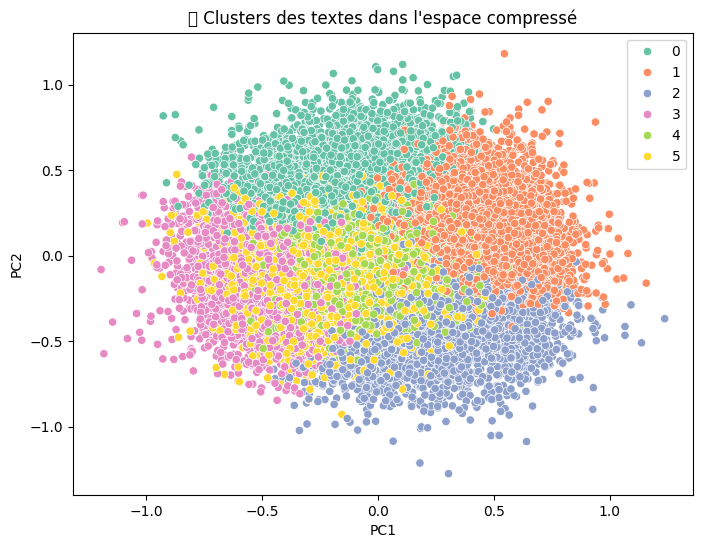

In [40]:
# Pour visualiser les clusters, on réduit à 2D avec PCA
pca_l1 = PCA(n_components=2)
X_pca_l1 = pca_l1.fit_transform(compressed_vectors_l1)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca_l1[:,0], y=X_pca_l1[:,1], hue=clusters_l1, palette='Set2')
plt.title("🧹 Clusters des textes dans l'espace compressé")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

/Users/ericcosterousse/.pyenv/versions/3.11.0/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


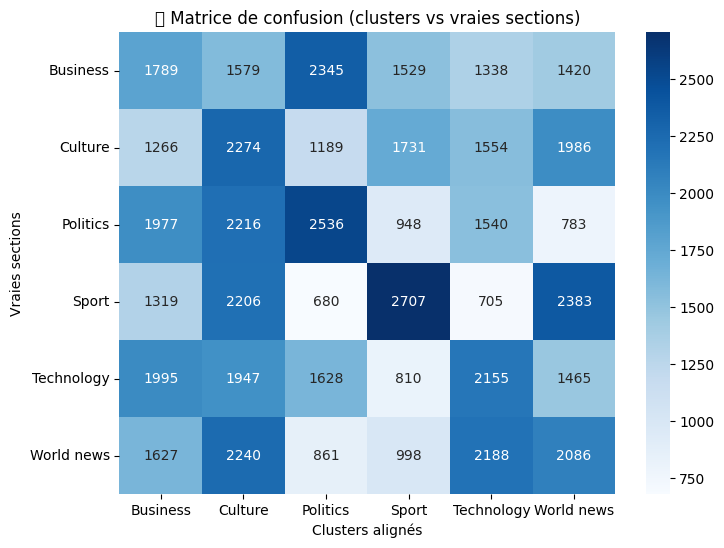

In [41]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

import numpy as np

# Étapes :
# 1. Vraies étiquettes (sections réelles)
true_labels_l1 = df["section"]

# 2. Encodage numérique des labels (si ce n'est pas déjà fait)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
true_labels_encoded_l1 = le.fit_transform(true_labels_l1)

# 3. Cluster prédits
pred_labels_l1 = df["cluster_l1"]

# 4. Réalignement des clusters avec les vraies étiquettes (car k-means donne des labels arbitraires)
# On crée la matrice de confusion brute
conf_matrix_l1 = confusion_matrix(true_labels_encoded_l1, pred_labels_l1)

# 5. On trouve la meilleure correspondance entre clusters et vraies classes
row_ind_l1, col_ind_l1 = linear_sum_assignment(-conf_matrix_l1)
aligned_pred_labels_l1 = np.zeros_like(pred_labels_l1)

for i, j in zip(col_ind_l1, row_ind_l1):
    aligned_pred_labels_l1[pred_labels_l1 == i] = j

# 6. Nouvelle matrice de confusion (alignée)
aligned_conf_matrix_l1 = confusion_matrix(true_labels_encoded_l1, aligned_pred_labels_l1)

# 7. Affichage
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(aligned_conf_matrix_l1, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Clusters alignés")
plt.ylabel("Vraies sections")
plt.title("🎯 Matrice de confusion (clusters vs vraies sections)")
plt.show()


In [ ]:
# Pour visualiser les clusters, on réduit à 2D avec PCA
pca_scaled = PCA(n_components=2)
X_pca_scaled = pca_scaled.fit_transform(compressed_vectors_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca_scaled[:,0], y=X_pca_scaled[:,1], hue=clusters_scaled, palette='Set2')
plt.title("🧹 Clusters des textes dans l'espace compressé")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

import numpy as np

# Étapes :
# 1. Vraies étiquettes (sections réelles)
true_labels_scaled = df["section"]

# 2. Encodage numérique des labels (si ce n'est pas déjà fait)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
true_labels_encoded_scaled = le.fit_transform(true_labels_scaled)

# 3. Cluster prédits
pred_labels_scaled = df["cluster_scaled"]

# 4. Réalignement des clusters avec les vraies étiquettes (car k-means donne des labels arbitraires)
# On crée la matrice de confusion brute
conf_matrix_scaled = confusion_matrix(true_labels_encoded_scaled, pred_labels_scaled)

# 5. On trouve la meilleure correspondance entre clusters et vraies classes
row_ind_scaled, col_ind_scaled = linear_sum_assignment(-conf_matrix_scaled)
aligned_pred_labels_scaled = np.zeros_like(pred_labels_scaled)

for i, j in zip(col_ind_scaled, row_ind_scaled):
    aligned_pred_labels_scaled[pred_labels_scaled == i] = j

# 6. Nouvelle matrice de confusion (alignée)
aligned_conf_matrix_scaled = confusion_matrix(true_labels_encoded_scaled, aligned_pred_labels_scaled)

# 7. Affichage
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(aligned_conf_matrix_scaled, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Clusters alignés")
plt.ylabel("Vraies sections")
plt.title("🎯 Matrice de confusion (clusters vs vraies sections)")
plt.show()
